<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_WDM_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of coherent WDM transmission

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm, signal_power
from optic.models.devices import pdmCoherentReceiver
from optic.models.channels import phaseNoise

try:
    from optic.models.modelsGPU import manakovSSF
except:
    from optic.models.channels import manakovSSF

from optic.models.tx import simpleWDMTx
from optic.utils import parameters, dBm2W
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.plot import pconst, plotPSD

import scipy.constants as const

import logging as logg
logg.basicConfig(level=logg.INFO, format='%(message)s', force=True)

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler


## Transmitter

**Polarization multiplexed WDM signal generation**

In [6]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 16           # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 2*4096     # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = -2        # power per WDM channel [dBm]
paramTx.Nch     = 11       # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3    # laser linewidth in Hz
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/11 [00:00<?, ?it/s]

channel 0	 fc : 192.9125 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 0	 power: -2.00 dBm

channel 1	 fc : 192.9500 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 1	 power: -2.00 dBm

channel 2	 fc : 192.9875 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 2	 power: -2.00 dBm

channel 3	 fc : 193.0250 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 3	 power: -2.00 dBm

channel 4	 fc : 193.0625 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 4	 power: -2.00 dBm

channel 5	 fc : 193.1000 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 5	 power: -2.00 dBm

channel 6	 fc : 193.1375 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 6	 power: -2.00 dBm

channel 7	 fc : 193.1750 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 7	 power: -2.00 dBm

channel 8	 fc : 193.2125 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
cha

**Nonlinear fiber propagation with the split-step Fourier method**

In [7]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 700     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift?
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = True   # show progress bar?
#paramCh.saveSpanN = [1, 5, 9, 14]
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

# nonlinear signal propagation
sigWDM, paramCh = manakovSSF(sigWDM_Tx, paramCh)

  0%|          | 0/14 [00:00<?, ?it/s]

**Optical WDM spectrum before and after transmission**

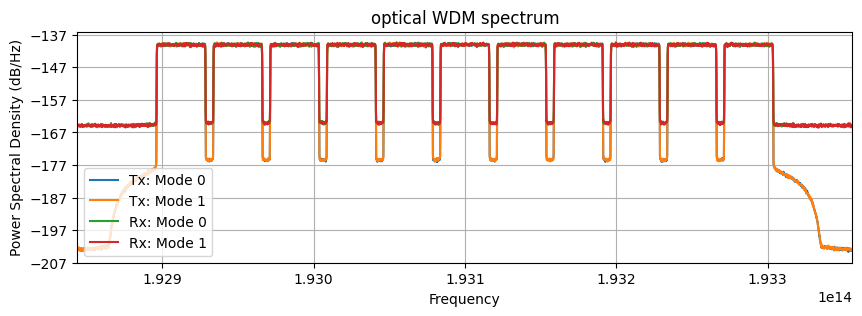

In [8]:
# plot psd
Fs = paramCh.Fs
fig,_ = plotPSD(sigWDM_Tx, Fs, paramCh.Fc, label='Tx'); 
fig, ax = plotPSD(sigWDM, Fs, paramCh.Fc, fig=fig, label='Rx');
fig.set_figheight(3)
fig.set_figwidth(10)
ax.set_title('optical WDM spectrum');

### WDM channels coherent detection and demodulation

Demodulating channel #5 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 150.00 MHz



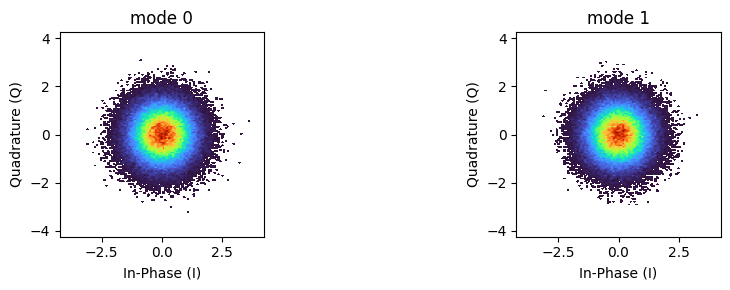

In [9]:
# Receiver

# parameters
chIndex  = int(np.floor(paramTx.Nch/2))      # index of the channel to be demodulated

Fc = paramCh.Fc
Ts = 1/Fs
freqGrid = paramTx.freqGrid

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 150e6                 # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated
lw      = 100e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = dBm2W(Plo_dBm)        # power in W
ϕ_lo    = 0                     # initial phase in rad    

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# generate LO field
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# polarization multiplexed coherent optical receiver

# photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs    
paramPD.ideal = True

θsig = π/3 # polarization rotation angle
sigRx = pdmCoherentReceiver(sigWDM, sigLO, θsig, paramPD)

# plot received constellations
pconst(sigRx[0::paramTx.SpS,:], R=3);

### Matched filtering and CD compensation

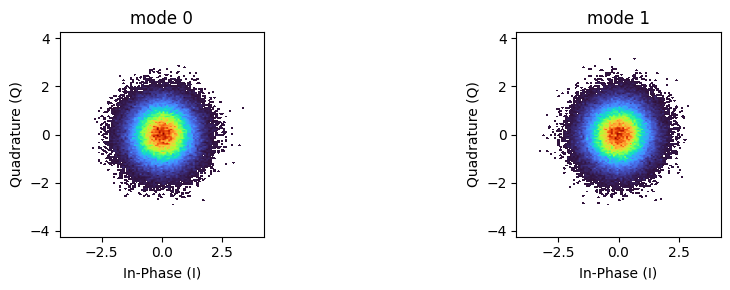

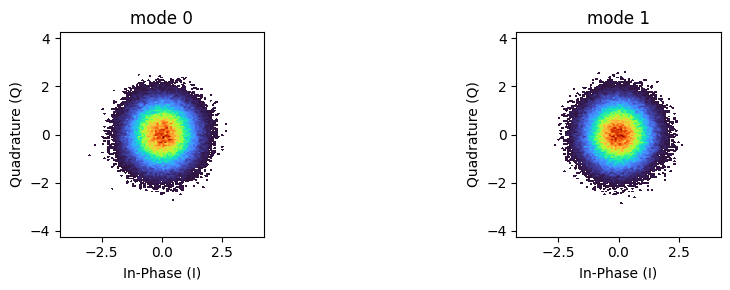

In [10]:
# Rx filtering

# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
    
pulse = pnorm(pulse)
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], R=3)

# CD compensation
paramEDC = parameters()
paramEDC.L = paramCh.Ltotal
paramEDC.D = paramCh.D
paramEDC.Fc = Fc-Δf_lo
paramEDC.Fs = Fs

sigRx = edc(sigRx, paramEDC)

# plot constellations after CD compensation
pconst(sigRx[0::paramTx.SpS,:], R=3);

### Downsampling to 2 samples/symbol and re-synchronization with transmitted sequences

In [11]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx, paramDec)

symbRx = symbolSync(sigRx, symbTx, 2)

### Power normalization

In [12]:
x = pnorm(sigRx)
d = pnorm(symbRx)

### Adaptive equalization

da-rde - training stage #0
da-rde pre-convergence training iteration #0
da-rde MSE = 0.020101.
da-rde pre-convergence training iteration #1
da-rde MSE = 0.018241.
da-rde pre-convergence training iteration #2
da-rde MSE = 0.018185.
da-rde pre-convergence training iteration #3
da-rde MSE = 0.018147.
da-rde pre-convergence training iteration #4
da-rde MSE = 0.018120.
rde - training stage #1
rde MSE = 0.012781.


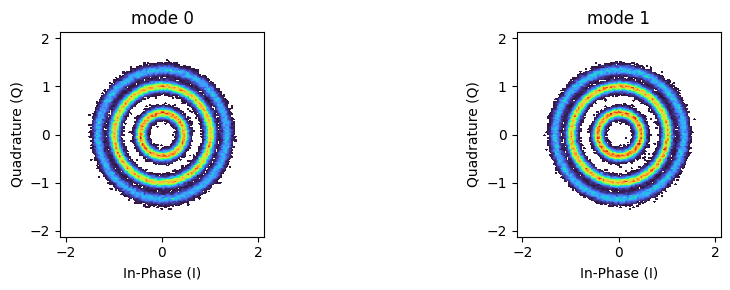

In [13]:
# adaptive equalization parameters
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = paramDec.SpS_out
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = paramTx.M
paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
paramEq.prgsBar = False

if paramTx.M == 4:
    paramEq.alg = ['cma','cma'] # QPSK
    paramEq.mu = [5e-3, 1e-3] 
else:
    paramEq.alg = ['da-rde','rde'] # M-QAM
    paramEq.mu = [5e-3, 2e-4] 
    
y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, d, paramEq)

#plot constellations after adaptive equalization
discard = 5000
pconst(y_EQ[discard:-discard,:], R=1.5);

### Carrier phase recovery

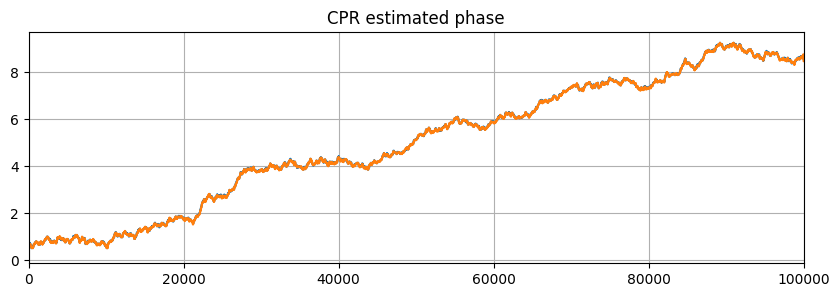

In [14]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 75
paramCPR.B   = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

y_CPR, θ = cpr(y_EQ, d, paramCPR)

y_CPR = pnorm(y_CPR)

plt.figure(figsize=(10, 3))
plt.title('CPR estimated phase')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

discard = 5000

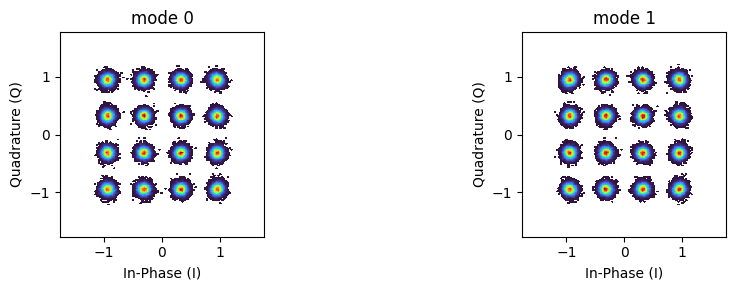

In [15]:
#plot constellations after CPR
pconst(y_CPR[discard:-discard,:]);

### Evaluate transmission metrics

In [16]:
ind = np.arange(discard, d.shape[0]-discard)

# remove phase and polarization ambiguities for QPSK signals
if paramTx.M == 4:   
    d = symbTx
    # find rotations after CPR and/or polarizations swaps possibly added at the output the adaptive equalizer:
    rot0 = [np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,0])), np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,0]))]
    rot1 = [np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,1])), np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,1]))]

    if np.argmax(np.abs(rot0)) == 1 and np.argmax(np.abs(rot1)) == 1:      
        y_CPR_ = y_CPR.copy() 
        # undo swap and rotation 
        y_CPR[:,0] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR_[:,1]) 
        y_CPR[:,1] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR_[:,0])
    else:
        # undo rotation
        y_CPR[:,0] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR[:,0])
        y_CPR[:,1] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR[:,1])
        

BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 21.54 dB,  21.56 dB
 EVM: 0.70 %,    0.70 %
  MI: 4.00 bits, 4.00 bits
 GMI: 4.00 bits, 4.00 bits
NGMI: 1.00,      1.00
